# Example 3.3 Recycling Robot

A mobile robot has the job of collecting empty soda cans in an oce environment. It
has sensors for detecting cans, and an arm and gripper that can pick them up and place
them in an onboard bin; it runs on a rechargeable battery. The robot’s control system
has components for interpreting sensory information, for navigating, and for controlling
the arm and gripper. High-level decisions about how to search for cans are made by a
reinforcement learning agent based on the current charge level of the battery. 

To make a simple example, we assume that only two charge levels can be distinguished, comprising
a small state set S = {high, low}. In each state, the agent can decide whether to 
- (1) actively search for a can for a certain period of time, 
- (2) remain stationary and wait for someone to bring it a can, or 
- (3) head back to its home base to recharge its battery.

When the energy level is high, recharging would always be foolish, so we do not include it
in the action set for this state. The action sets are then A(high) = {search, wait} and
A(low) = {search, wait, recharge}.

The rewards are zero most of the time, but become positive when the robot secures an
empty can, or large and negative if the battery runs all the way down. The best way to
find cans is to actively search for them, but this runs down the robot’s battery, whereas
waiting does not. Whenever the robot is searching, the possibility exists that its battery
will become depleted. In this case the robot must shut down and wait to be rescued
(producing a low reward). If the energy level is high, then a period of active search can
always be completed without risk of depleting the battery. A period of searching that
begins with a high energy level leaves the energy level high with probability $\alpha$ and reduces
it to low with probability 1 - $\alpha$. On the other hand, a period of searching undertaken
when the energy level is low leaves it low with probability $\beta$ and depletes the battery
with probability 1 - $\beta$. In the latter case, the robot must be rescued, and the battery is
then recharged back to high. Each can collected by the robot counts as a unit reward,
whereas a reward of -3 results whenever the robot has to be rescued. Let r$_{search}$ and
r$_{wait}$, with r$_{search}$ > r$_{wait}$, respectively denote the expected number of cans the robot
will collect (and hence the expected reward) while searching and while waiting. Finally,
suppose that no cans can be collected during a run home for recharging, and that no cans
can be collected on a step in which the battery is depleted.

<img src="robot.png">

In [56]:
# Imports
import random
import matplotlib.pyplot as plt
import numpy as np

In [57]:
class Environment:
    """
    Model simulation of the office environment 
    for the Recycle Robot Example.
    Includes random cans in the office at each run.
    """
    
    def __init__(self):
        self.alpha = random.uniform(0.01, 0.5)
        self.beta = random.uniform(0.01, 0.5)
        self.high = 0
        self.low = 1
        self.search = 0
        self.wait = 1
        self.recharge = 2
        self.searching = 1
        self.waiting = 0.1
        self.rescue = -3
        self.S = [self.high, self.low]
        self.A = [self.search, self.wait, self.recharge]
        self.model = self.create_model()
        self.R = self.create_rewards()
        
    def create_model(self):
        """
        Create a tabular dynamics model for the simulated environment
        Create action probabilities for p(s'|s,a)
        model = dict<k,v> keys: states, values: array of action probability tuples
        """
        
        # model
        model = {
            self.high: [
                (self.alpha, 1-self.alpha), 
                (0, 0),
            ], 
            self.low: [
                (self.beta, 1-self.beta), 
                (0, 0), 
                (1, 0)
            ]
        }
        
        return model
    
    def create_rewards(self):
        """
        Create a tabular dynamics r(s,a,s') model for the simulated environment
        """
        
        # reward model
        reward = {
            self.high: [
                (self.searching, self.searching), 
                (self.waiting, 0),
            ], 
            self.low: [
                (self.rescue, self.searching), 
                (0, self.waiting), 
                (0, 0)
            ]
        }
        
        return reward
    
    def p(self, s, a, sprime):
        """
        Returns Transition Probability p(s'|s,a)
        """
        
        return self.model[s][a][sprime]
    
    def r(self, s, a, sprime):
        """
        Returns reward for s, a, s'
        """
        
        return self.R[s][a][sprime]

In [58]:
env = Environment()

In [59]:
env.A

[0, 1, 2]

In [60]:
env.S

[0, 1]

In [61]:
env.R

{0: [(1, 1), (0.1, 0)], 1: [(-3, 1), (0, 0.1), (0, 0)]}

In [62]:
env.p(0, 0, 1)

0.825531514800546

In [63]:
class Agent:
    
    def __init__(self):
        self.pi = [[0.5, 0.33, 0], [0.33, 0.33, 0.33]]
        self.gamma = 0.9
    
    def step(self, s, a, env, V):
        """
        Mutates V from agent action
        """
        
        # Summation value
        value = 0
        
        # Bootstrap next states from current (s,a)
        for sprime in env.S:
            
            # Bellman Update
            value += self.pi[s][a]*env.p(s, a, sprime)*(env.r(s,a,sprime) + self.gamma*V[sprime])
        
        return value
        

In [64]:
agent = Agent()

In [65]:
# Policy
policy = {0: [0, 1], 1: [0, 1, 2]}

# Value function
V = [0, 0]

# Algorithm parameters
delta = theta = 0.0001

# Loop:
while delta >= theta:
    
    # Delta <-- 0
    delta = 0
    
    # Loop for each state
    for s, actions in policy.items():
        
        # v <-- V(s)
        v = V[s]
        
        # values for value function 
        value = 0
        
        # Test all actions
        for a in actions:
            
            # Sum every action
            value += agent.step(s, a, env, V)
            
        # Assign update to value function
        V[s] = value
        
        # Delta = max(delta, |v-V(s)|)
        delta = max(delta, abs(v-V[s]))

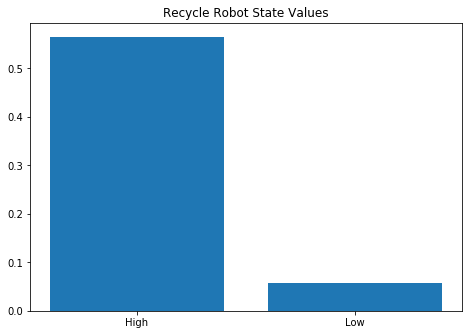

In [97]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
states = ['High', 'Low']
values = V
ax.bar(states, values)
ax.set_title("Recycle Robot State Values")
plt.show()